# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [1]:
!python -m pip install --user --upgrade pip
!pip install xgboost --user --upgrade
!pip install lightgbm --user --upgrade

distutils: C:\Users\KK\AppData\Roaming\Python\Python38\Include\UNKNOWN
sysconfig: C:\Users\KK\AppData\Roaming\Python\Python38\Include
user = True
home = None
root = None
prefix = None


distutils: C:\Users\KK\AppData\Roaming\Python\Python38\Include\UNKNOWN
sysconfig: C:\Users\KK\AppData\Roaming\Python\Python38\Include
user = True
home = None
root = None
prefix = None


distutils: C:\Users\KK\AppData\Roaming\Python\Python38\Include\UNKNOWN
sysconfig: C:\Users\KK\AppData\Roaming\Python\Python38\Include
user = True
home = None
root = None
prefix = None


In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics

In [3]:
### Preprocessing
def prep(df_origin):
    df = df_origin.copy()
    
    # 자료형 변환
    col = []
    if df['ZN'].dtype == 'object':
        for i in df['ZN']:
            col.append(float(i[1:-1]))
        df['ZN'] = col

    col = []
    if df['CHAS'].dtype == 'object':
        for i in df['CHAS']:
            col.append(float(i[1:-1]))
        df['CHAS'] = col

    # 결측값 처리
    for i in df.columns[df.isnull().sum() != 0]:
        if i not in ['INDUS', 'RM']:
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            df[i].fillna(df[i].median(), inplace=True)
            
    return df


def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def feature_engineering(df_origin):
    df = df_origin.copy()
    
    # 데이터 변환
    interval = [100, 200, 300, 400, 500, 600, 700, 800]
    if df['TAX'].max() >= 100:
        df['TAX'] = np.digitize(df['TAX'], bins=interval)
        
    if 'TAX' in df.columns:
        df_dummy = pd.get_dummies(df['TAX'], prefix='TAX', drop_first=True)
        df = pd.concat([df, df_dummy], axis=1)
        del df['TAX']

    df['CHAS'] = df['CHAS'].astype(int)
    if 'CHAS' in df.columns:
        df_dummy = pd.get_dummies(df['CHAS'], prefix='CHAS', drop_first=False)
        df = pd.concat([df, df_dummy], axis=1)
        del df['CHAS']

    if 'CHAS' in df.columns:
        del df['CHAS']
    
    return df


def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    
    # checking the difference of columns
    X_te_noncol = [i for i in X_tr.columns if i not in X_te.columns]
    X_tr_noncol = [i for i in X_te.columns if i not in X_tr.columns]

    # duplicates
    if X_te_noncol != []:
        for i in X_te_noncol:
            X_te[i] = 0
            X_te = X_te[X_tr.columns].copy()
            
    if X_tr_noncol != []:
        for i in X_tr_noncol:
            X_tr[i] = 0
            X_tr = X_tr[X_te.columns].copy()
            
    return X_tr, X_te


def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    
    return Score, Residual

### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte, Residual_tr, Residual_te


### Error analysis
def error_analysis(X_Data, Y_Pred, Residual, graph_on=False):
    if graph_on == True:
        ##### Error Analysis(Plot)
        # Normal Distribution Analysis
        sns.distplot(Residual, norm_hist='True', fit=stats.norm)
        plt.show()

        # Autocorrelation Analysis
        plt.figure(figsize=(12,5))
        sm.graphics.tsa.plot_acf(Residual, lags=50, use_vlines=True)
        plt.show()

        # Heteroscedasticity Analysis
        temp = pd.concat([pd.DataFrame(Y_Pred, columns=['Estimated Price']),
                          Residual.reset_index().iloc[:,[1]]], axis=1)
        sns.scatterplot(x='Estimated Price', y='Error', data=temp)
        plt.show()

    ##### Error Analysis(Statistics)
    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    Error_Analysis = pd.concat([Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    Error_Analysis
    
    return Error_Analysis

# Base Algorithm: Linear Regression

(404, 13) (404, 1)
(102, 13) (102, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     68.67
Date:                Sun, 25 Apr 2021   Prob (F-statistic):          2.71e-105
Time:                        17:14:20   Log-Likelihood:                -1188.7
No. Observations:                 404   AIC:                             2413.
Df Residuals:                     386   BIC:                             2486.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -9.7685      3.129     -3.122      0.002     -15.921      -3.616
ZN             3.6059      1.538      2.345      0.020       0.583       6.629
INDUS         -1.0711      1.956     -0.548      0.584      -4.917       2.774
NOX           -6.8870      2.163     -3.184      0.002     -11.140      -2.634
RM            28.7478      2.137     13.453      0.000      24.546      32.949
AGE           -3.1799      1.386     -2.294      0.022      -5.906      -0.454
DIS          -14.1170      2.480     -5.691      0.000     -18.994      -9.240
RAD           10.9837      4.247      2.586      0.010       2.633      19.334
PTRATIO       -8.1534      1.388     -5.874      0.000     -10.882      -5.424
B              4.1760      1.233      3.387      0.001       1.752       6.600
LSTAT        -10.0753      2.011     -5.010      0.000     -14.029      -6.122
TAX_2         -5.2255      1.405     -3.719      0.000      -7.988      -2.463
TAX_3         -5.7704      1.463     -3.945      0.000      -8.646      -2.894
TAX_4         -5.2109      1.538     -3.389      0.001      -8.234      -2.187
TAX_6        -13.2573      4.293     -3.088      0.002     -21.697      -4.817
TAX_7         -6.4422      2.668     -2.414      0.016     -11.688      -1.196
CHAS_0        24.9203      2.976      8.374      0.000      19.069      30.771
CHAS_1        26.4669      3.197      8.279      0.000      20.181      32.753
==============================================================================
Omnibus:                      241.516   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3120.749
Skew:                           2.289   Prob(JB):                         0.00
Kurtosis:                      15.823   Cond. No.                         50.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,3.07,21.05,16.33
Test,3.51,31.34,16.76


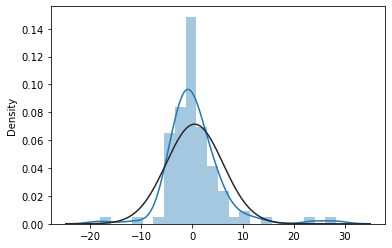

<Figure size 864x360 with 0 Axes>

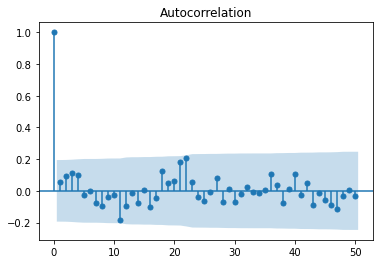

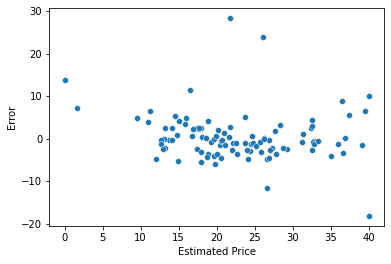

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.83,5.77,41.83,0.13
p-value,0.00,0.83,0.79,0.00
Alternative,nan,nan,nan,two-sided


In [4]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

# Regression
algo_lr = sm.OLS(Y_train, X_train_fes).fit()
display(algo_lr.summary())

Y_trpred = algo_lr.predict(X_train_fes).values
Y_tepred = algo_lr.predict(X_test_fes).values

# Evaluation
Score, Resid_tr, Resid_te = evaluation_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score)

# Error Analysis
error_analysis(X_test_fes, Y_tepred, Resid_te, graph_on=True)

# Advanced Algorithm: Regularization

## Ridge

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,3.05,21.26,16.13
Test,3.49,30.99,16.53


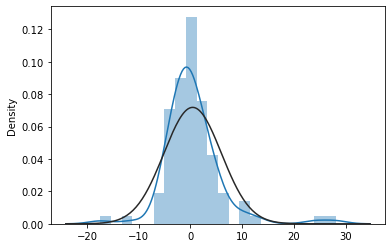

<Figure size 864x360 with 0 Axes>

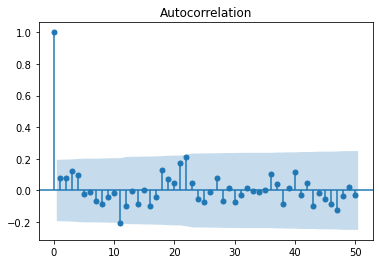

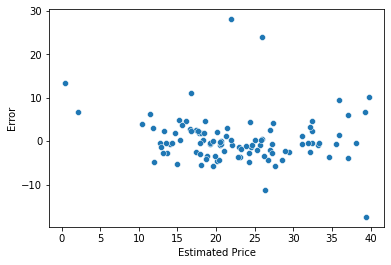

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.83,5.70,44.24,0.13
p-value,0.00,0.84,0.70,0.00
Alternative,nan,nan,nan,two-sided


In [5]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Regularization
# Ridge
algo_ridge = Ridge(alpha=0.5, fit_intercept=True, 
                   normalize=False, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_ridge = algo_ridge.predict(X_train_fes).flatten()
Y_tepred_ridge = algo_ridge.predict(X_test_fes).flatten()

# Evaluation
Score_ridge, \
Resid_tr_ridge, Resid_te_ridge = evaluation_trte(Y_train, Y_trpred_ridge,
                                                 Y_test, Y_tepred_ridge, 
                                                 graph_on=False)
display(Score_ridge)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_ridge, Resid_te_ridge, graph_on=True)

## Lasso

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,4.27,38.64,22.38
Test,4.65,45.53,21.33


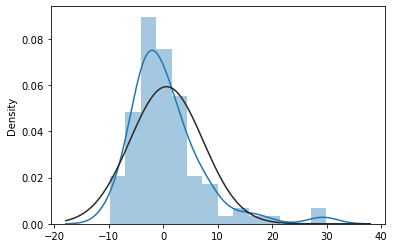

<Figure size 864x360 with 0 Axes>

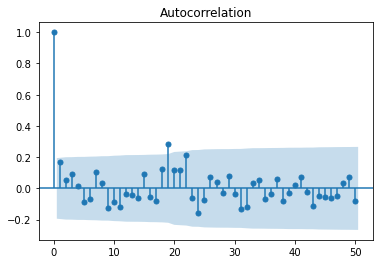

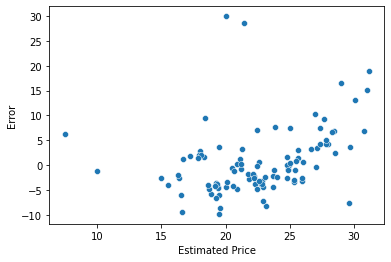

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.85,9.73,59.75,0.13
p-value,0.00,0.46,0.16,0.00
Alternative,nan,nan,nan,two-sided


In [6]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Regularization
# Lasso
algo_lasso = Lasso(alpha=0.5, fit_intercept=True, 
                   normalize=False, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_lasso = algo_lasso.predict(X_train_fes).flatten()
Y_tepred_lasso = algo_lasso.predict(X_test_fes).flatten()

# Evaluation
Score_lasso, \
Resid_tr_lasso, Resid_te_lasso = evaluation_trte(Y_train, Y_trpred_lasso,
                                                 Y_test, Y_tepred_lasso, 
                                                 graph_on=False)
display(Score_lasso)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_lasso, Resid_te_lasso, graph_on=True)

## Elastic Net

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,3.21,23.95,16.31
Test,3.54,30.79,16.11


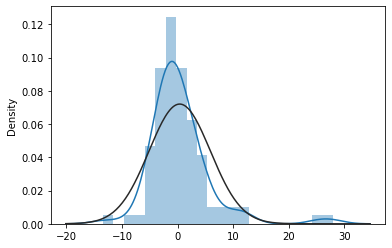

<Figure size 864x360 with 0 Axes>

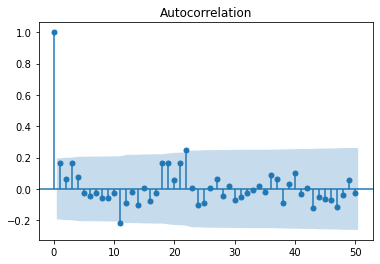

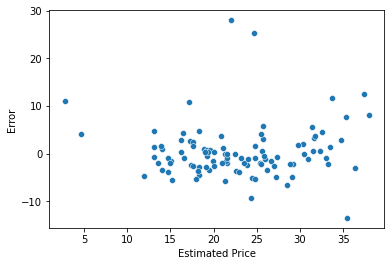

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.82,8.10,54.81,0.13
p-value,0.00,0.62,0.30,0.00
Alternative,nan,nan,nan,two-sided


In [7]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Regularization
# ElasticNet
algo_en = ElasticNet(alpha=0.01, l1_ratio=0.1, fit_intercept=True, 
                   normalize=False, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_en = algo_en.predict(X_train_fes).flatten()
Y_tepred_en = algo_en.predict(X_test_fes).flatten()

# Evaluation
Score_en, \
Resid_tr_en, Resid_te_en = evaluation_trte(Y_train, Y_trpred_en,
                                           Y_test, Y_tepred_en, 
                                           graph_on=False)
display(Score_en)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_en, Resid_te_en, graph_on=True)

# Advanced Algorithm: Bagging

## Decision Tree

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,0.00,0.00,0.00
Test,4.24,50.78,21.12


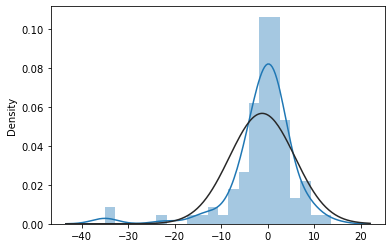

<Figure size 864x360 with 0 Axes>

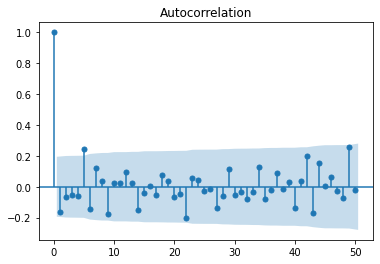

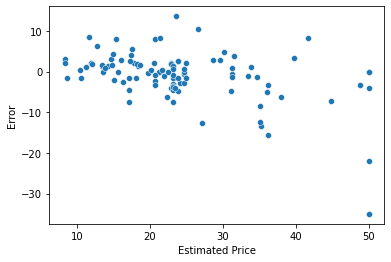

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.79,18.38,78.42,0.39
p-value,0.00,0.05,0.01,0.01
Alternative,nan,nan,nan,two-sided


In [8]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Bagging
# DecisionTree
algo_dt = DecisionTreeRegressor().fit(X_train_fes, Y_train)
Y_trpred_dt = algo_dt.predict(X_train_fes).flatten()
Y_tepred_dt = algo_dt.predict(X_test_fes).flatten()

# Evaluation
Score_dt, \
Resid_tr_dt, Resid_te_dt = evaluation_trte(Y_train, Y_trpred_dt,
                                           Y_test, Y_tepred_dt, 
                                           graph_on=False)
display(Score_dt)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_dt, Resid_te_dt, graph_on=True)

## Random Forest

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,0.86,1.55,4.42
Test,2.71,25.67,13.21


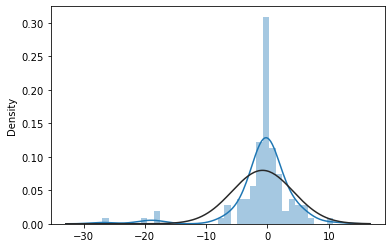

<Figure size 864x360 with 0 Axes>

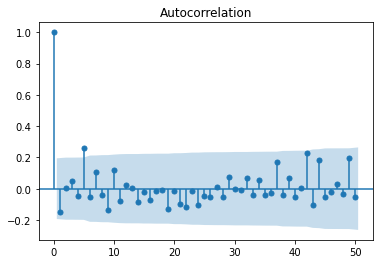

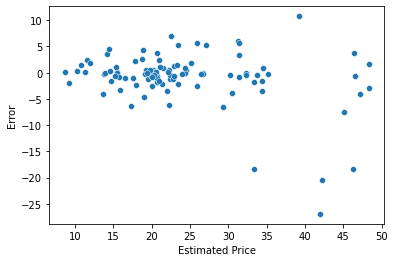

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.73,15.91,62.15,0.12
p-value,0.00,0.10,0.12,0.00
Alternative,nan,nan,nan,two-sided


In [9]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Bagging
# RandomForestRegressor
algo_rf = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_rf = algo_rf.predict(X_train_fes).flatten()
Y_tepred_rf = algo_rf.predict(X_test_fes).flatten()

# Evaluation
Score_rf, \
Resid_tr_rf, Resid_te_rf = evaluation_trte(Y_train, Y_trpred_rf,
                                           Y_test, Y_tepred_rf, 
                                           graph_on=False)
display(Score_rf)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_rf, Resid_te_rf, graph_on=True)

# Advanced Algorithm: Boosting

## Gradient Boosting

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,1.64,10.24,8.62
Test,2.95,26.95,12.50


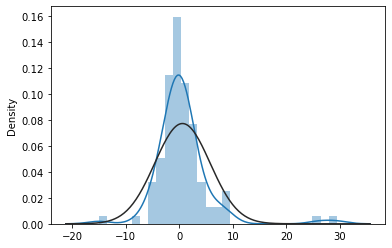

<Figure size 864x360 with 0 Axes>

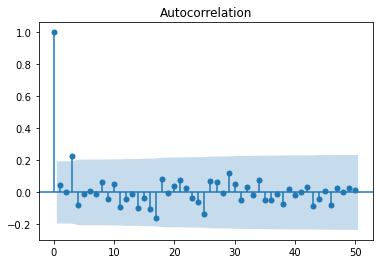

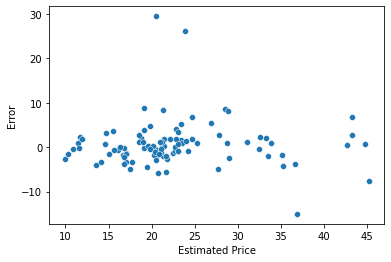

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.74,7.31,29.89,0.09
p-value,0.00,0.70,0.99,0.00
Alternative,nan,nan,nan,two-sided


In [10]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Boosting
# GradientBoostingRegression
algo_gb = GradientBoostingRegressor(alpha=0.1, learning_rate=0.05, 
                                    loss='huber', criterion='friedman_mse',
                                    n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_gb = algo_gb.predict(X_train_fes).flatten()
Y_tepred_gb = algo_gb.predict(X_test_fes).flatten()

# Evaluation
Score_gb, \
Resid_tr_gb, Resid_te_gb = evaluation_trte(Y_train, Y_trpred_gb,
                                           Y_test, Y_tepred_gb, 
                                           graph_on=False)
display(Score_gb)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_gb, Resid_te_gb, graph_on=True)

## XGBoost

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,0.74,0.97,3.91
Test,2.58,20.57,11.75


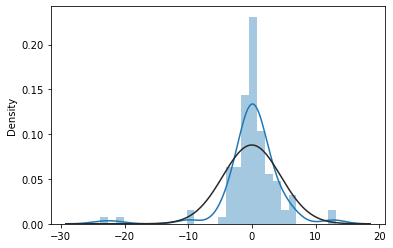

<Figure size 864x360 with 0 Axes>

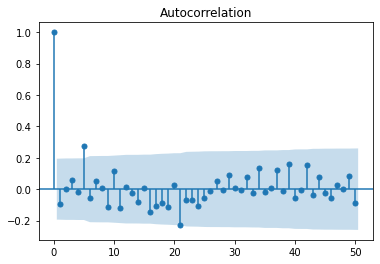

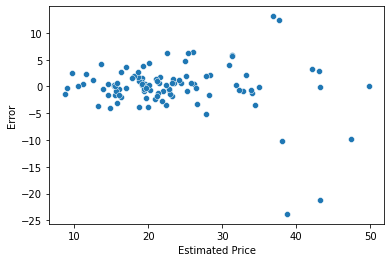

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.77,13.26,54.94,0.11
p-value,0.00,0.21,0.29,0.00
Alternative,nan,nan,nan,two-sided


In [11]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Boosting
# XGBoost
algo_xgb = XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_xgb = algo_xgb.predict(X_train_fes).flatten()
Y_tepred_xgb = algo_xgb.predict(X_test_fes).flatten()

# Evaluation
Score_xgb, \
Resid_tr_xgb, Resid_te_xgb = evaluation_trte(Y_train, Y_trpred_xgb,
                                             Y_test, Y_tepred_xgb, 
                                             graph_on=False)
display(Score_xgb)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_xgb, Resid_te_xgb, graph_on=True)

## LightGBM

(404, 13) (404, 1)
(102, 13) (102, 1)


,MAE,MSE,MAPE
Train,1.34,4.95,7.05
Test,2.76,24.79,12.65


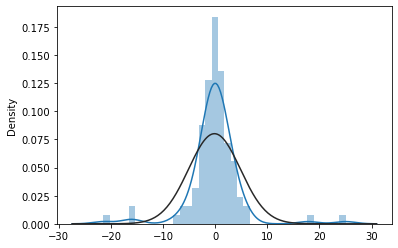

<Figure size 864x360 with 0 Axes>

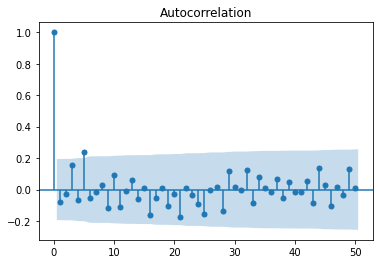

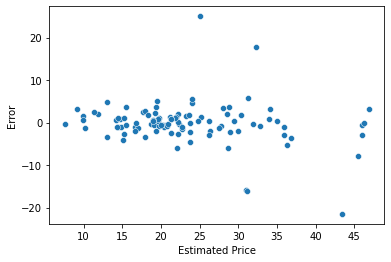

,Normality,Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,0.75,12.98,50.82,0.10
p-value,0.00,0.22,0.44,0.00
Alternative,nan,nan,nan,two-sided


In [12]:
# Data Loading
location = r'.\Data\BostonHousingPrice\Price_Modify_KK.csv'
df = pd.read_csv(location)

# Preprocessing
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Boosting
# LightGMB
algo_lgbm = LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_lgbm = algo_lgbm.predict(X_train_fes).flatten()
Y_tepred_lgbm = algo_lgbm.predict(X_test_fes).flatten()

# Evaluation
Score_lgbm, \
Resid_tr_lgbm, Resid_te_lgbm = evaluation_trte(Y_train, Y_trpred_lgbm,
                                               Y_test, Y_tepred_lgbm, 
                                               graph_on=False)
display(Score_lgbm)

# Error Analysis
error_analysis(X_test_fes, Y_tepred_lgbm, Resid_te_lgbm, graph_on=True)

# Comparison: Top Algorithm

In [13]:
print('Score: Linear')
display(Score)
print('Score: Regularization')
display(Score_ridge, Score_lasso, Score_en)
print('Score: Bagging')
display(Score_dt, Score_rf)
print('Score: Boosting')
display(Score_gb, Score_xgb, Score_lgbm)

Score: Linear


,MAE,MSE,MAPE
Train,3.07,21.05,16.33
Test,3.51,31.34,16.76


Score: Regularization


,MAE,MSE,MAPE
Train,3.05,21.26,16.13
Test,3.49,30.99,16.53


,MAE,MSE,MAPE
Train,4.27,38.64,22.38
Test,4.65,45.53,21.33


,MAE,MSE,MAPE
Train,3.21,23.95,16.31
Test,3.54,30.79,16.11


Score: Bagging


,MAE,MSE,MAPE
Train,0.00,0.00,0.00
Test,4.24,50.78,21.12


,MAE,MSE,MAPE
Train,0.86,1.55,4.42
Test,2.71,25.67,13.21


Score: Boosting


,MAE,MSE,MAPE
Train,1.64,10.24,8.62
Test,2.95,26.95,12.50


,MAE,MSE,MAPE
Train,0.74,0.97,3.91
Test,2.58,20.57,11.75


,MAE,MSE,MAPE
Train,1.34,4.95,7.05
Test,2.76,24.79,12.65
